### **Creating the directories for Training and Testing Data**

In [37]:
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import cv2
import os
from PIL import Image

test_zip_file_path = "/content/marker_images_test.zip"
test_data_dir = "/content/marker_images_test"

with zipfile.ZipFile(test_zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(test_data_dir )


train_zip_file_path = "/content/marker_images_train.zip"
train_data_dir  = "/content/marker_images_train"

with zipfile.ZipFile(train_zip_file_path , 'r') as zip_ref:
    zip_ref.extractall(train_data_dir )


### **Data preprocessing**

- **Pre-processing before feeding to network**
    1. I have converted the input images to the RGB color space to ensure the compatibility with the pre-trained model
    2. In paper , it was mentioned the pre-trained model worked well with input images of a specific size (224x224).  I have also resized the input images to the expected size to ensure that the spatial dimensions match the model's architecture.
    3. I have normalized the input data using mean and standard deviation of the ImageNet dataset, which was used to pre-train the ResNet-18 model :

In [38]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [39]:
def normalize_image(img):
    return (img.astype(np.float32) / 255.0 - mean) / std


def load_data(data_dir):
    images = []
    labels = []

    for folder_name in os.listdir(data_dir):
        test_folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(test_folder_path):
            for subfolder_name in os.listdir(test_folder_path):
                subfolder_path = os.path.join(test_folder_path, subfolder_name)
                if os.path.isdir(subfolder_path):
                    for sub_subfolder_name in os.listdir(subfolder_path):
                        sub_subfolder_path = os.path.join(subfolder_path, sub_subfolder_name)
                        if os.path.isdir(sub_subfolder_path):
                            image_files = [file for file in os.listdir(sub_subfolder_path) if file.endswith('.png')]
                            if len(image_files) != 2:
                                continue

                            image_files.sort()

                            img1 = cv2.imread(os.path.join(sub_subfolder_path, image_files[0]))
                            img2 = cv2.imread(os.path.join(sub_subfolder_path, image_files[1]))
                            if img1 is None or img2 is None:
                                continue

                            # Converting from BGR to RGB
                            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
                            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

                            # Resizing images to 224x224
                            img1 = cv2.resize(img1, (224, 224))
                            img2 = cv2.resize(img2, (224, 224))

                            # Applying normalization
                            img1 = normalize_image(img1)
                            img2 = normalize_image(img2)

                            images.append((img1, img2))

                            label_file_path = None
                            for file in os.listdir(sub_subfolder_path):
                                if file.endswith('.txt'):
                                    label_file_path = os.path.join(sub_subfolder_path, file)
                                    break
                            if label_file_path is None or not os.path.exists(label_file_path):
                                continue

                            with open(label_file_path, 'r') as file:
                                line_labels = []
                                for line in file:
                                    line_labels.append(float(line.strip())*224/640)
                            labels.append(line_labels)

    return np.array(images), np.array(labels)

In [40]:
test_data_directory = "/content/marker_images_test"
test_images, test_labels = load_data(test_data_directory)

In [41]:
train_data_directory = "/content/marker_images_train"
train_images, train_labels = load_data(train_data_directory)

In [42]:
print('Shape of train_images:', train_images.shape)
print('Shape of train_labels:', train_labels.shape)
print('Shape of test_images:', test_images.shape)
print('Shape of test_labels:', test_labels.shape)


Shape of train_images: (1324, 2, 224, 224, 3)
Shape of train_labels: (1324, 2)
Shape of test_images: (1316, 2, 224, 224, 3)
Shape of test_labels: (1316, 2)


### **Dataset Preparation to be fed to the network**


In [43]:
train_dataset = TensorDataset(torch.from_numpy(train_images), torch.from_numpy(train_labels))
test_dataset = TensorDataset(torch.from_numpy(test_images), torch.from_numpy(test_labels))

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### **Modified ResNet18 architecture**

1. The final fully connected layer has been replaced with an MLP
2. The forward method has been modified to process two input images separately feeding them to the designed network , concatenate their features, and pass them through the final MLP for delta x and delta y prediction.

I have changed my previous MLP structure , to make it more complex with more layers  (I thought may be it is simple and cannot capture the intricacies of our displacement data)  +  I have added dropout layers  (to prevent overfitting)

In [44]:
class BuildingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(BuildingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)

        return x

In [45]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        # First Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self.create_layer(64, 64, stride=1)
        self.layer2 = self.create_layer(64, 128, stride=2)
        self.layer3 = self.create_layer(128, 256, stride=2)
        self.layer4 = self.create_layer(256, 512, stride=2)

        # Final Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # MLP for regression
        self.mlp = nn.Sequential(
            nn.Linear(512 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def create_layer(self, in_channels, out_channels, stride):
        identity_downsample = None

        if stride != 1:
            identity_downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_channels)
            )

        return nn.Sequential(
            BuildingBlock(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            BuildingBlock(out_channels, out_channels)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # rearranging the dimensions of the tensor
        # to match the expected input format for the ResNet (batch, channels, height, width).
        x1 = x[:, 0, ...].permute(0, 3, 1, 2)
        x2 = x[:, 1, ...].permute(0, 3, 1, 2)


        x1 = self.relu(self.bn1(self.conv1(x1)))
        x1 = self.maxpool(x1)

        x2 = self.relu(self.bn1(self.conv1(x2)))
        x2 = self.maxpool(x2)

        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = self.layer3(x1)
        x1 = self.layer4(x1)

        x2 = self.layer1(x2)
        x2 = self.layer2(x2)
        x2 = self.layer3(x2)
        x2 = self.layer4(x2)


        x = torch.cat((x1, x2), dim=1)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.mlp(x)

        return x

### **Pretrained ResNet34 architecture**


In [51]:
import torchvision.models as models

class ResNet34_pretrained(nn.Module):
    def __init__(self):
        super(ResNet34_pretrained, self).__init__()
        self.resnet = models.resnet34(pretrained=True)

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        self.mlp = nn.Sequential(
            nn.Linear(num_ftrs * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Rearranging the dimensions of the tensor
        # to match the expected input format for the ResNet (batch, channels, height, width).
        x1 = x[:, 0, ...].permute(0, 3, 1, 2)
        x2 = x[:, 1, ...].permute(0, 3, 1, 2)

        x1 = self.resnet(x1)
        x2 = self.resnet(x2)

        x = torch.cat((x1, x2), dim=1)
        x = self.mlp(x)
        return x


### **Model Training and Evaluation**

In [52]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.float().to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)

        '''
        print("OUTPUT")
        print(outputs)

        print("LABEL")
        print(labels)

        '''
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(train_loader.dataset)


In [53]:
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.float().to(device), labels.float().to(device)
            outputs = model(images)
            # print(outputs)
            # print(labels)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    return running_loss / len(test_loader.dataset)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 208MB/s]


Epoch [1/5], Train Loss: 0.0188, Test Loss: 0.0018
Epoch [2/5], Train Loss: 0.0110, Test Loss: 0.0007
Epoch [3/5], Train Loss: 0.0095, Test Loss: 0.0005
Epoch [4/5], Train Loss: 0.0079, Test Loss: 0.0004
Epoch [5/5], Train Loss: 0.0070, Test Loss: 0.0004


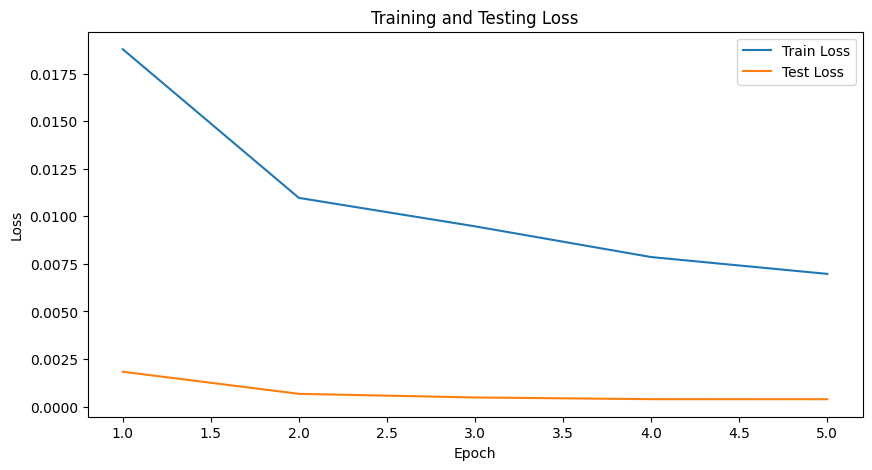

In [54]:
import matplotlib.pyplot as plt

model = ResNet34_pretrained()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

num_epochs = 5
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss = test(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### **Rollout Experiments**

In [55]:
def load_data(data_dir):
    sub_sub_folders = []
    for folder_name in os.listdir(data_dir):
        sub_folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(sub_folder_path):
            for sub_sub_folder_name in sorted(os.listdir(sub_folder_path)):
                sub_sub_folder_path = os.path.join(sub_folder_path, sub_sub_folder_name)
                if os.path.isdir(sub_sub_folder_path):
                    sub_sub_folders.append(sub_sub_folder_path)
    return sub_sub_folders

In [56]:
def apply_deltas(image, delta):
    delta_y = int(delta[0, 1] * 224)
    delta_x = int(delta[0, 0] * 224)

    lower_purple = (np.array([20, 0, 20]) / 255.0 - mean) / std
    upper_purple = (np.array([255, 0, 255]) / 255.0 - mean) / std

    mask = cv2.inRange(image, lower_purple, upper_purple)

    purple_mask = mask == 255

    shifted_purple_pixels_y = np.clip(np.where(purple_mask)[0] + delta_y, 0, 223)
    shifted_purple_pixels_x = np.clip(np.where(purple_mask)[1] + delta_x, 0, 223)

    shifted_image = np.copy(image)
    shifted_image[np.where(purple_mask)] = [255, 255, 255]
    shifted_image[shifted_purple_pixels_y, shifted_purple_pixels_x] = image[np.where(purple_mask)]

    return shifted_image

In [57]:
def visualize_gripper_movement(initial_image, ground_truth_image, new_image):
    plt.figure(figsize=(18, 6))

    # Converting initial, ground truth, and new images to the correct depth
    initial_image = initial_image.astype(np.uint8)
    ground_truth_image = ground_truth_image.astype(np.uint8)
    new_image = new_image.astype(np.uint8)

    # Plotting the initial image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(initial_image, cv2.COLOR_BGR2RGB))
    plt.title('Initial State')
    plt.axis('off')

    # Plotting the new image
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
    plt.title('State achieved')
    plt.axis('off')

    # Plotting the ground truth image
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(ground_truth_image, cv2.COLOR_BGR2RGB))
    plt.title('State to achieve')
    plt.axis('off')

    plt.show()

In [58]:
import re

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]



def rollout_experiment(model, sub_sub_folder):
    sub_sub_folders = [os.path.join(sub_sub_folder, f) for f in os.listdir(sub_sub_folder) if os.path.isdir(os.path.join(sub_sub_folder, f))]
    sub_sub_folders.sort(key=natural_sort_key)

    folder_num = 1

    for folder_path in sub_sub_folders:
        images = []
        image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
        image_files.sort(key=natural_sort_key)

        print("***************** Images Considered ************************")
        if folder_num == 1 :

          img1 = cv2.imread(os.path.join(folder_path,  image_files[0]))
          img2 = cv2.imread(os.path.join(folder_path,  image_files[1]))

          print(os.path.join(folder_path,  image_files[0]))
          print(os.path.join(folder_path,  image_files[1]))

          # Converting from BGR to RGB
          img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
          img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

          # Resizing images to 224x224
          img1 = cv2.resize(img1, (224, 224))
          img2 = cv2.resize(img2, (224, 224))

          # Applying normalization
          img1 = normalize_image(img1)
          img2 = normalize_image(img2)


          if img1 is not None or img2 is not None:
             images.append((img1, img2))

          images = np.array(images)


        else :
          img1 = new_image
          img2 = cv2.imread(os.path.join(folder_path,  image_files[1]))

          print(os.path.join(folder_path,  image_files[1]))

          img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
          img2 = cv2.resize(img2, (224, 224))
          img2 = normalize_image(img2)


          if img1 is not None or img2 is not None:
             images.append((img1, img2))

          images = np.array(images)

        images_pair = TensorDataset(torch.from_numpy(images))
        images_loader = DataLoader(images_pair, batch_size = 1 , shuffle=False)

        model.eval()
        with torch.no_grad():
            for batch in images_loader:
                images = batch[0].float().to(device)
                delta = model(images)
                print("\n ********************** Delta Values : ********************")
                print(delta*640/224)
                new_image = apply_deltas(img1, delta)
                visualize_gripper_movement(img1, img2, new_image)

        folder_num +=1

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test1/000.png
/content/marker_images_test/marker_images_test/1681324565/test1/001.png

 ********************** Delta Values : ********************
tensor([[0.0606, 0.0710]], device='cuda:0')


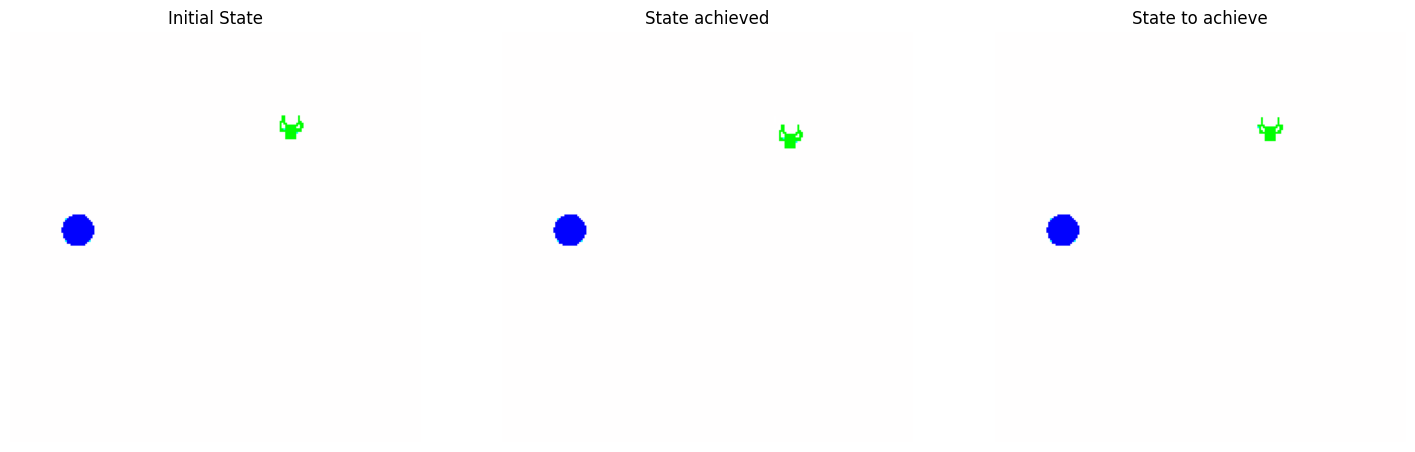

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test2/002.png

 ********************** Delta Values : ********************
tensor([[-1.2805,  0.5052]], device='cuda:0')


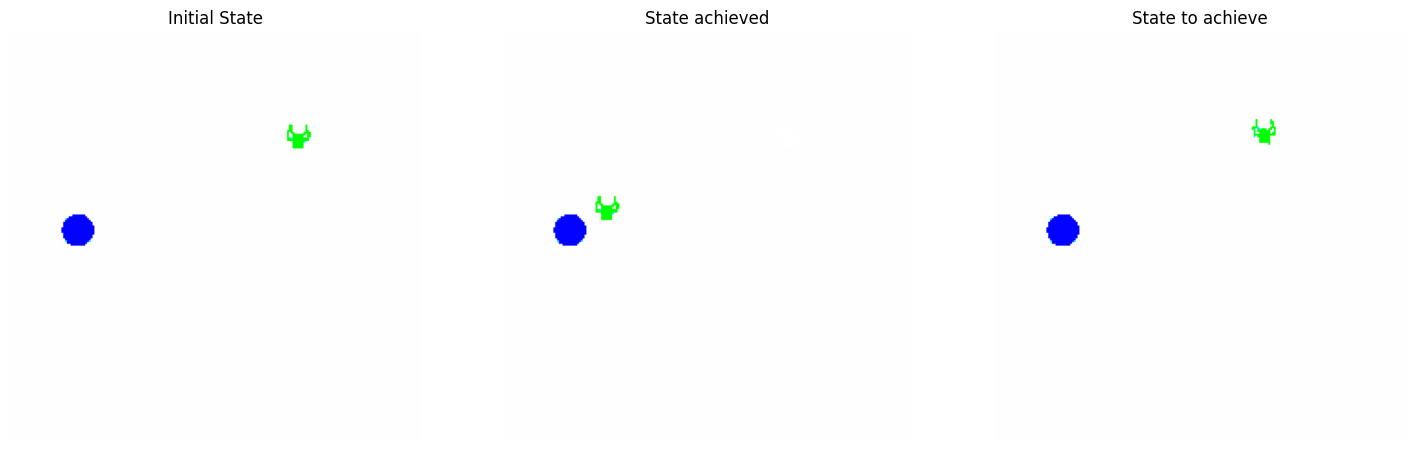

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test3/003.png

 ********************** Delta Values : ********************
tensor([[-1.4472,  0.1393]], device='cuda:0')


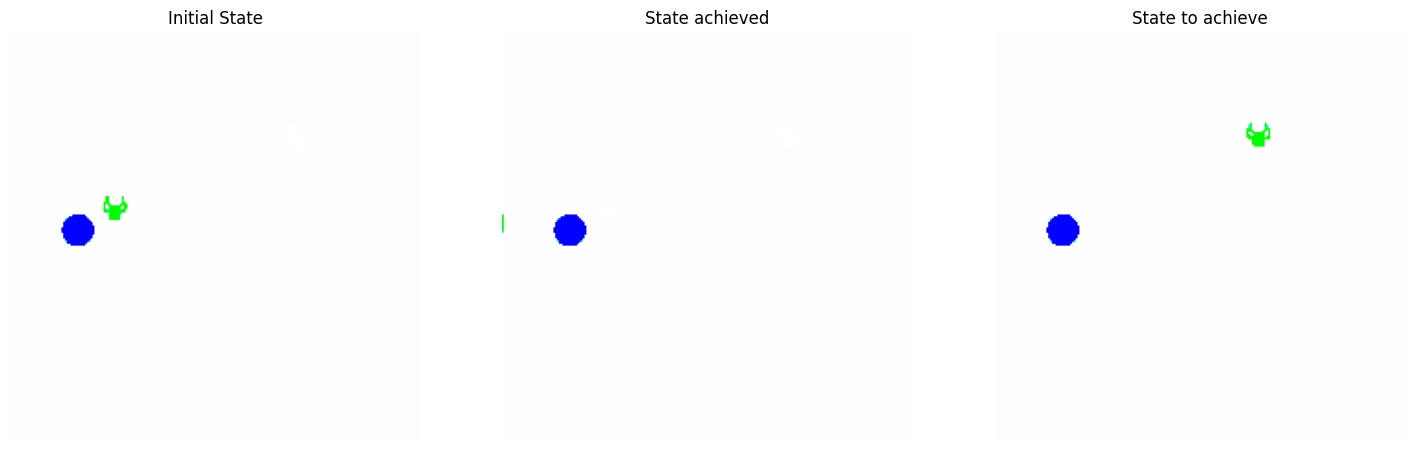

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test4/004.png

 ********************** Delta Values : ********************
tensor([[-2.8912,  0.6572]], device='cuda:0')


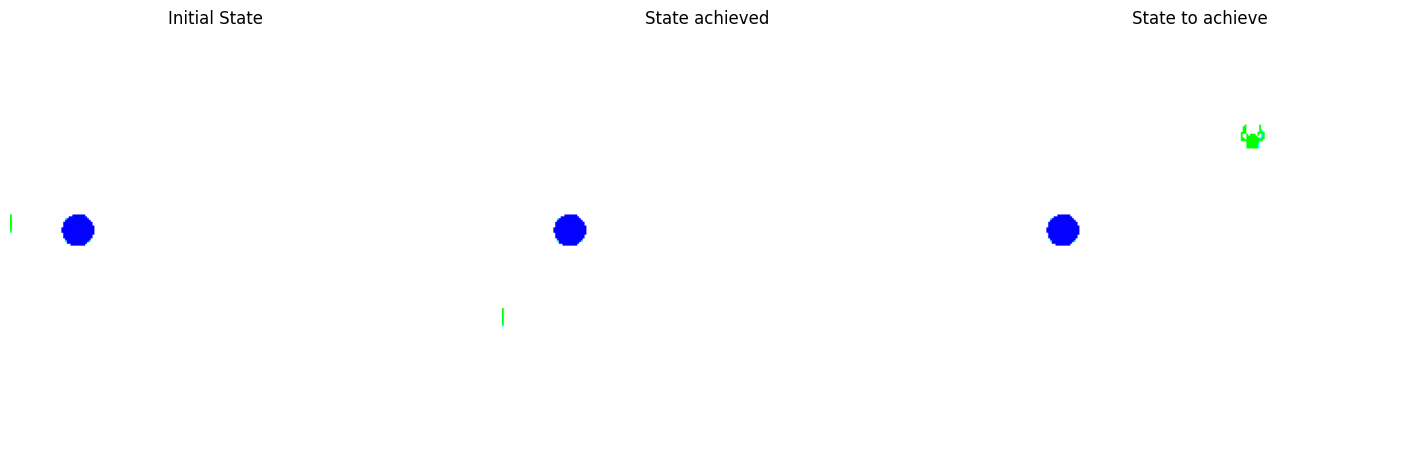

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test5/005.png

 ********************** Delta Values : ********************
tensor([[-2.7584,  0.5534]], device='cuda:0')


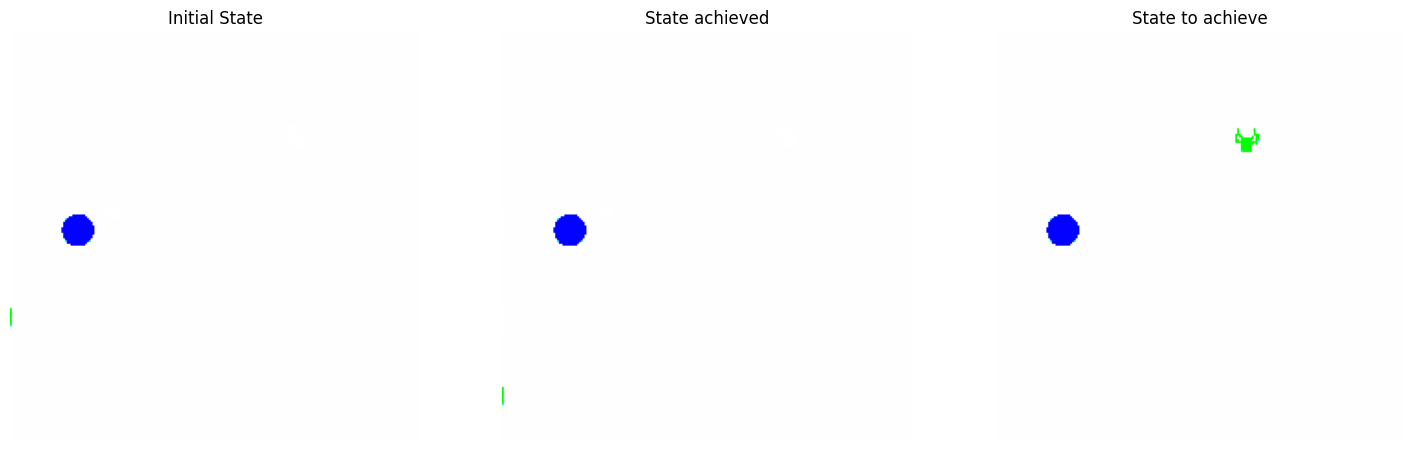

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test6/006.png

 ********************** Delta Values : ********************
tensor([[-2.8275,  0.4101]], device='cuda:0')


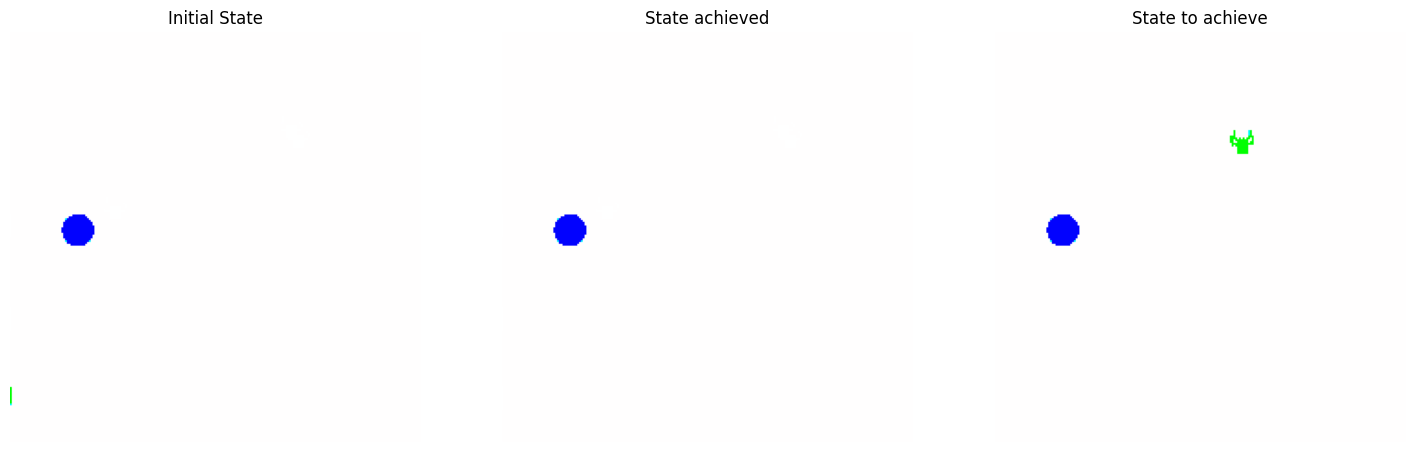

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test7/007.png

 ********************** Delta Values : ********************
tensor([[-2.9091,  0.3558]], device='cuda:0')


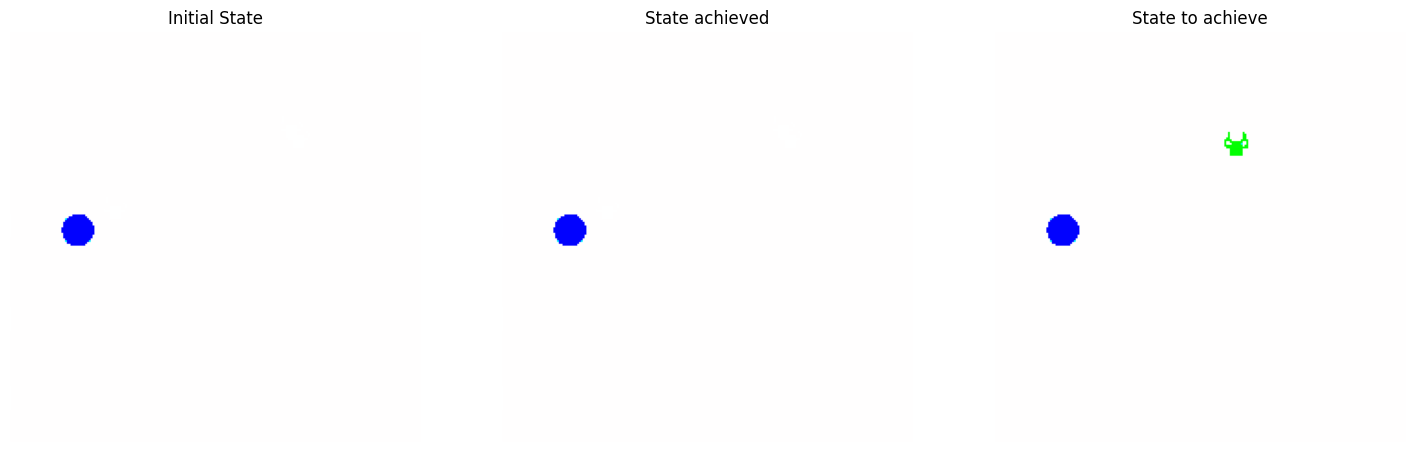

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test8/008.png

 ********************** Delta Values : ********************
tensor([[-2.8651,  0.3234]], device='cuda:0')


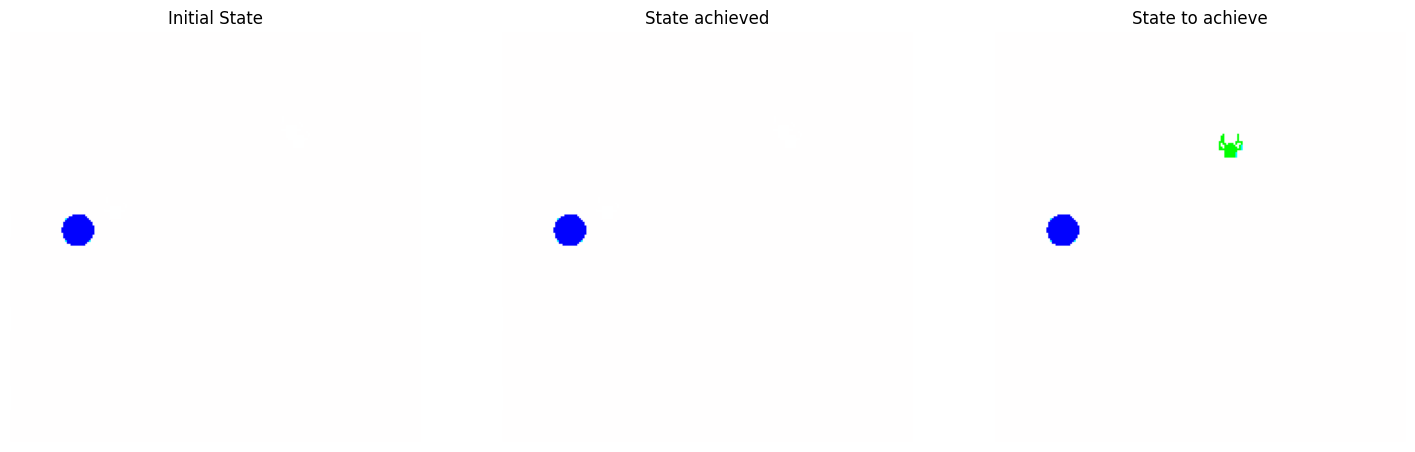

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test9/009.png

 ********************** Delta Values : ********************
tensor([[-2.8743,  0.3374]], device='cuda:0')


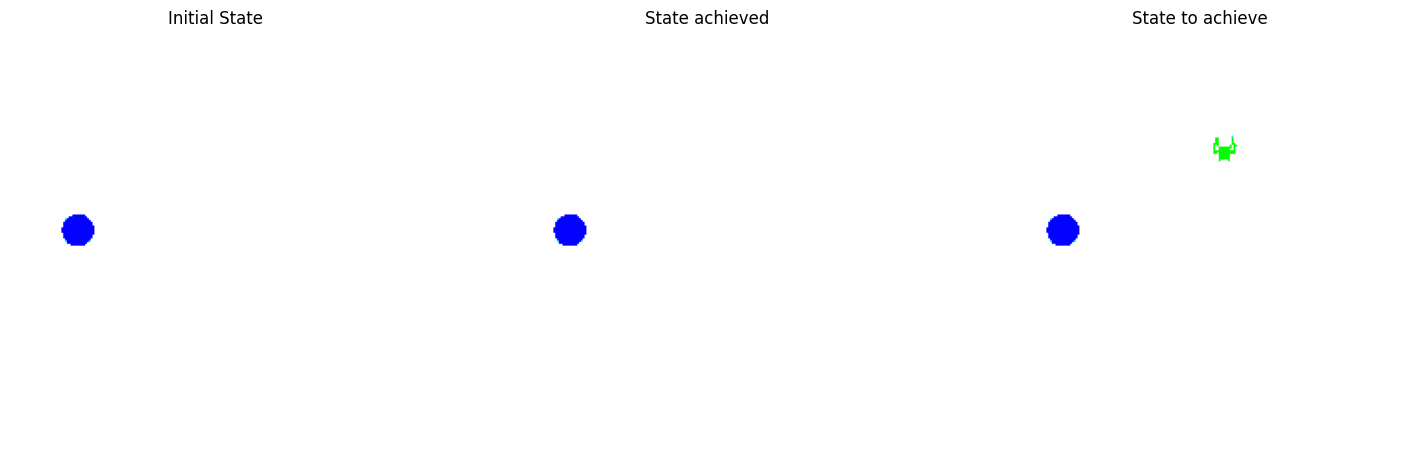

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test10/010.png

 ********************** Delta Values : ********************
tensor([[-2.9200,  0.4038]], device='cuda:0')


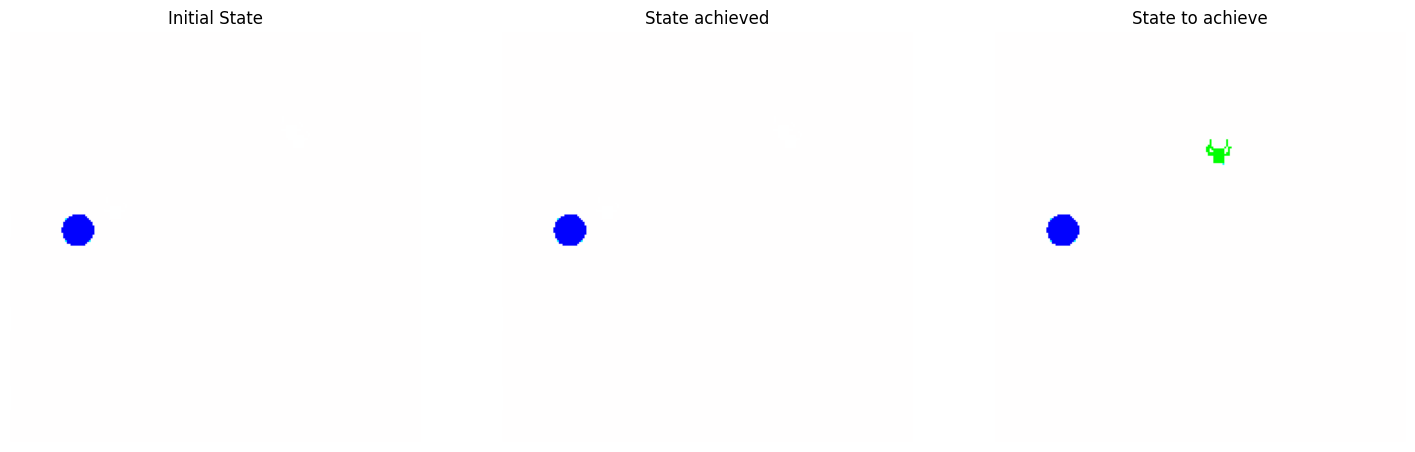

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test11/011.png

 ********************** Delta Values : ********************
tensor([[-2.9608,  0.4143]], device='cuda:0')


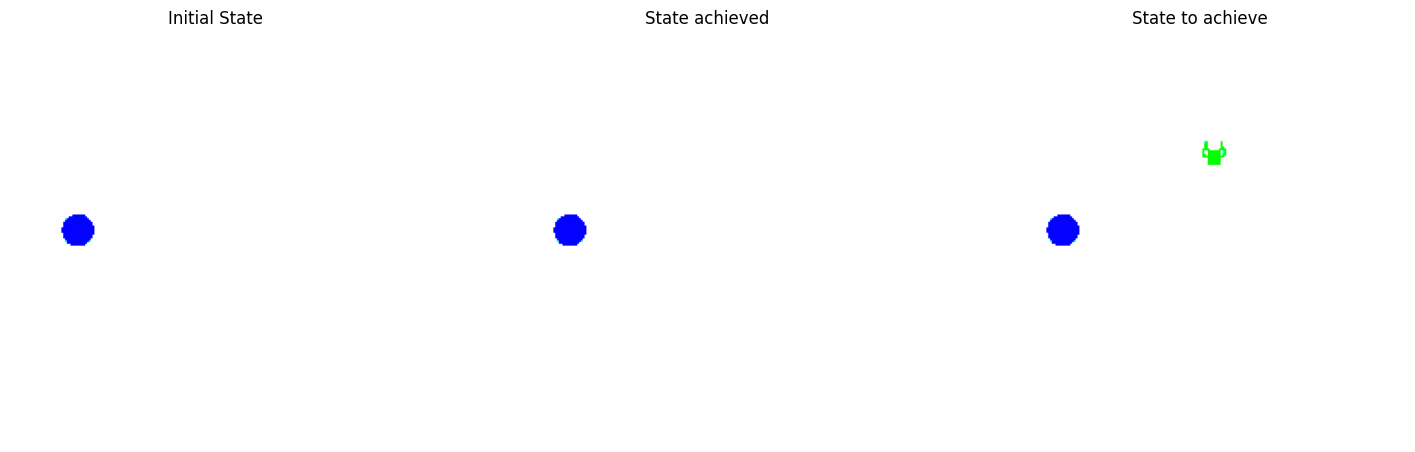

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test12/012.png

 ********************** Delta Values : ********************
tensor([[-2.9009,  0.4078]], device='cuda:0')


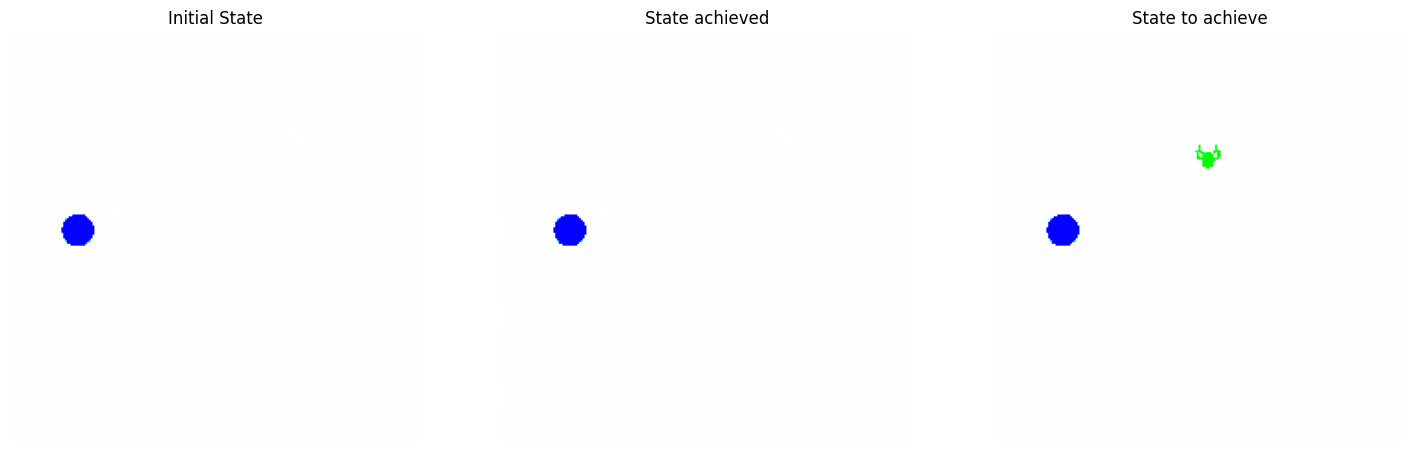

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test13/013.png

 ********************** Delta Values : ********************
tensor([[-2.8987,  0.3981]], device='cuda:0')


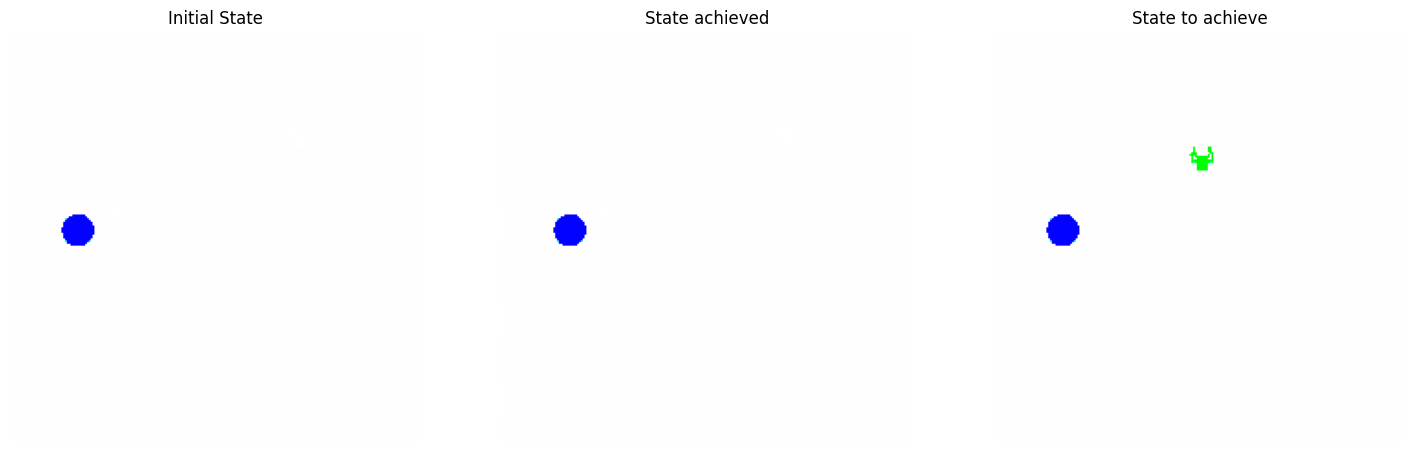

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test14/014.png

 ********************** Delta Values : ********************
tensor([[-2.9113,  0.3354]], device='cuda:0')


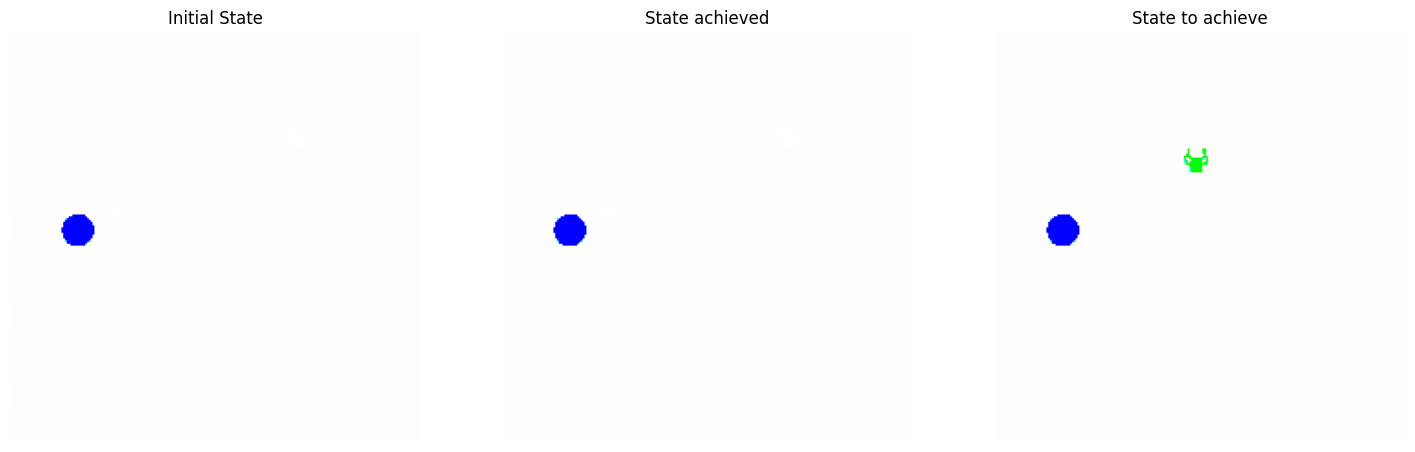

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test15/015.png

 ********************** Delta Values : ********************
tensor([[-2.9577,  0.3938]], device='cuda:0')


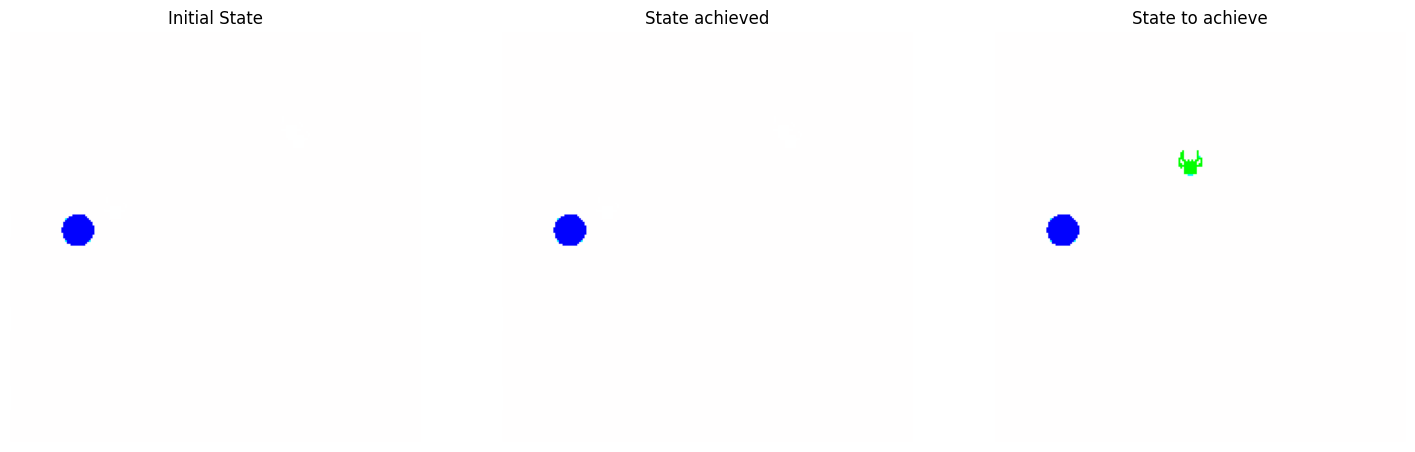

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test16/016.png

 ********************** Delta Values : ********************
tensor([[-2.9453,  0.3753]], device='cuda:0')


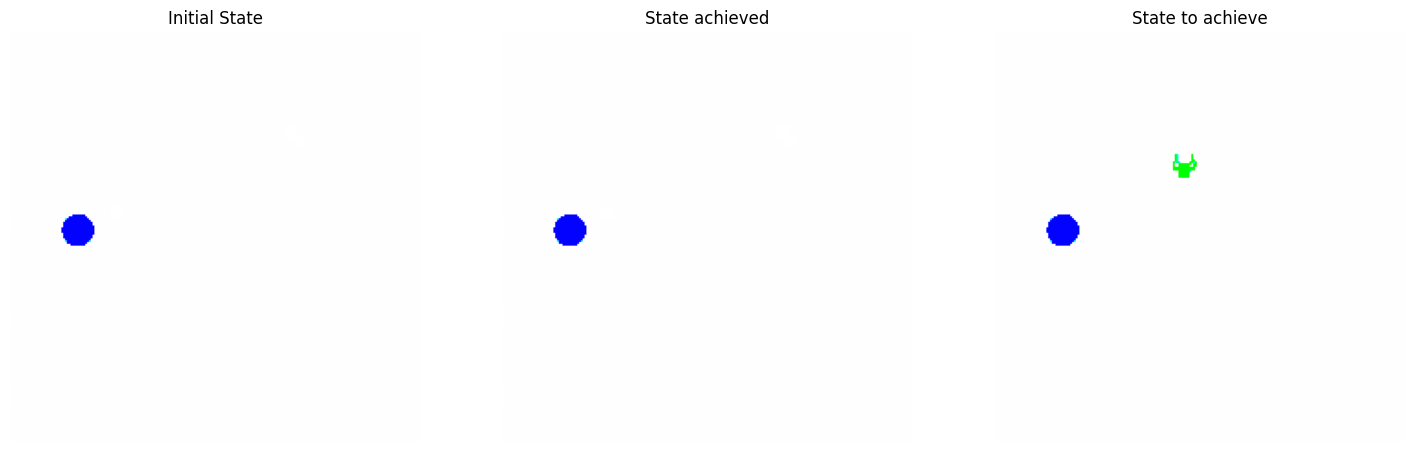

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test17/017.png

 ********************** Delta Values : ********************
tensor([[-2.9438,  0.4002]], device='cuda:0')


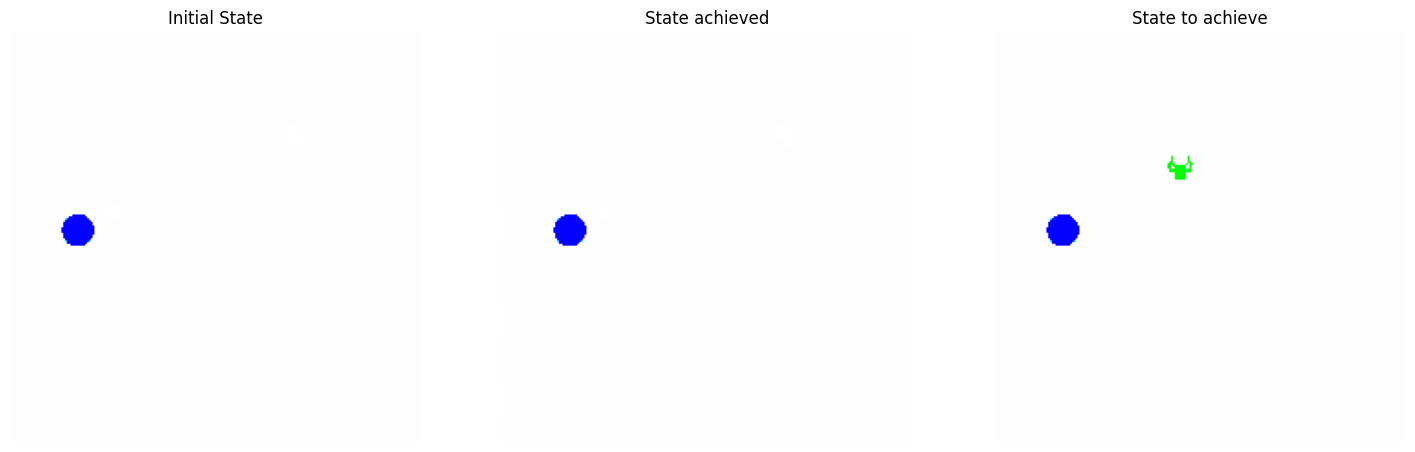

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test18/018.png

 ********************** Delta Values : ********************
tensor([[-2.9120,  0.3462]], device='cuda:0')


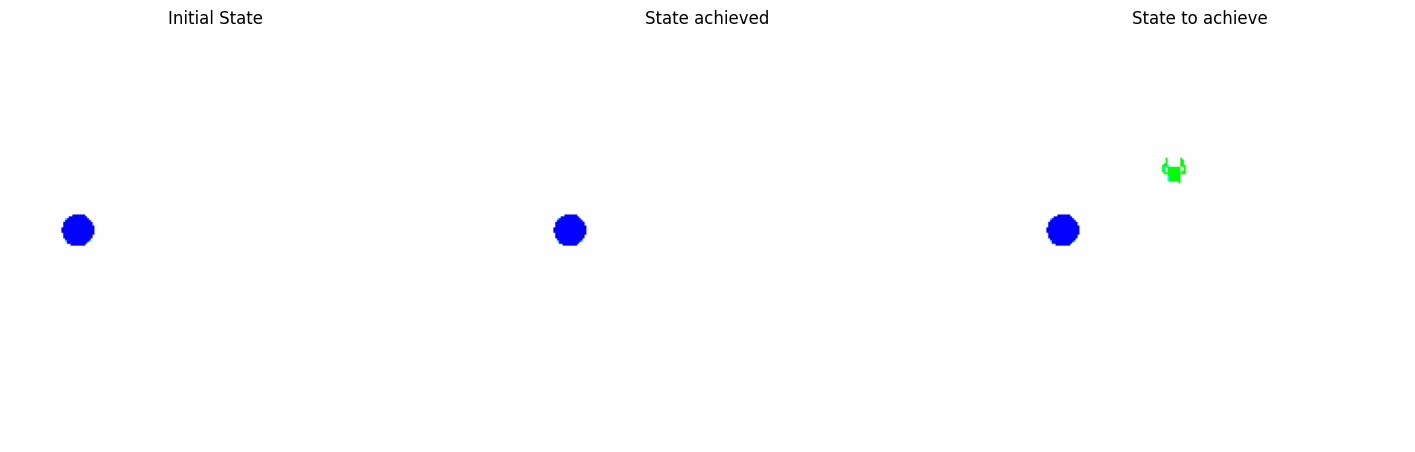

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test19/019.png

 ********************** Delta Values : ********************
tensor([[-2.8337,  0.3134]], device='cuda:0')


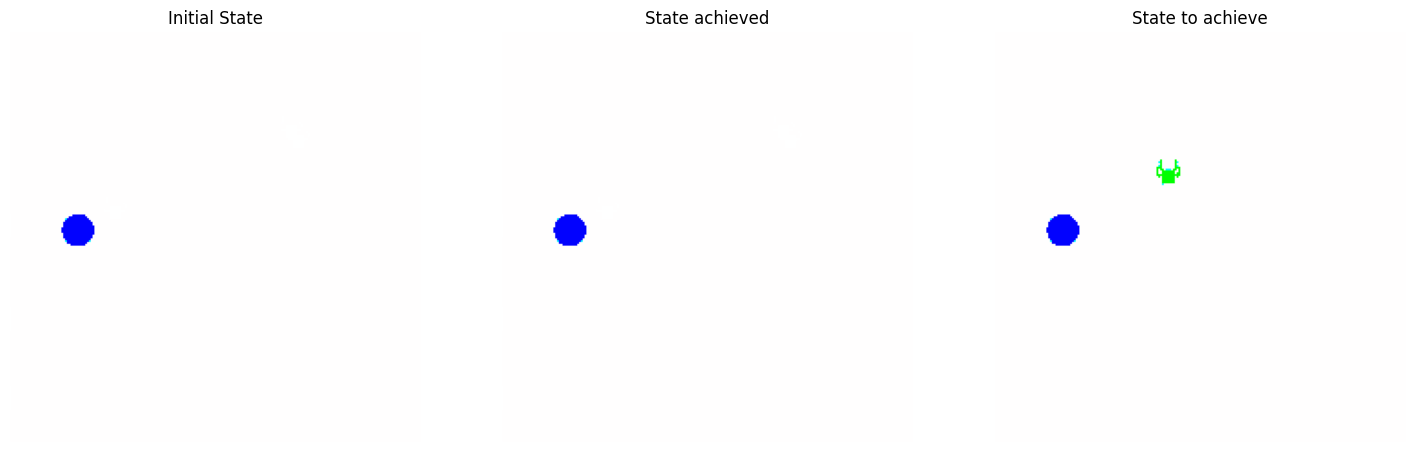

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test20/020.png

 ********************** Delta Values : ********************
tensor([[-3.0608,  0.3970]], device='cuda:0')


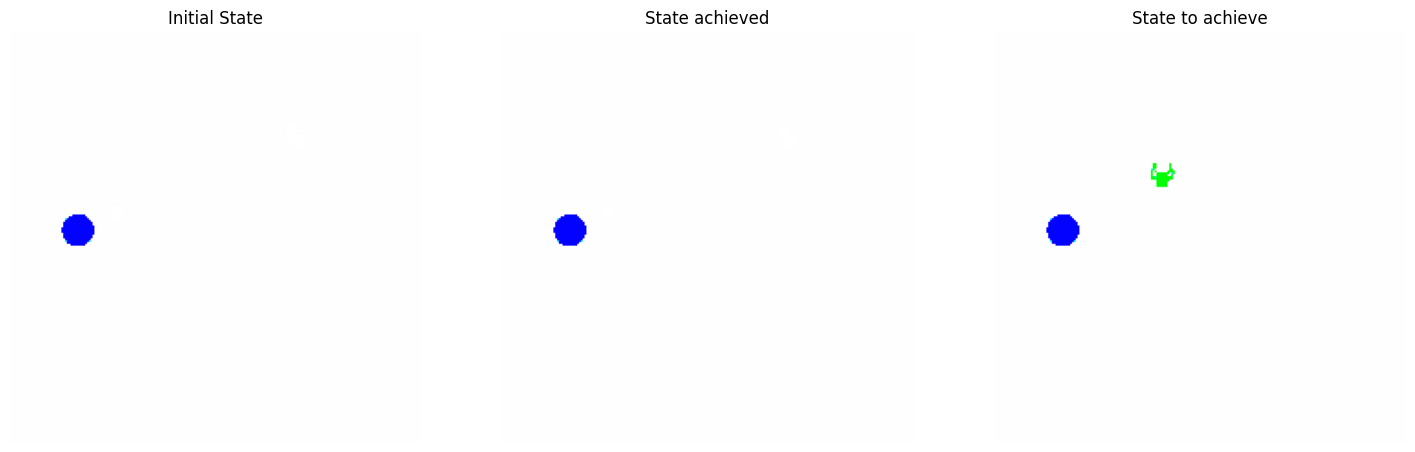

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test21/021.png

 ********************** Delta Values : ********************
tensor([[-2.9907,  0.4034]], device='cuda:0')


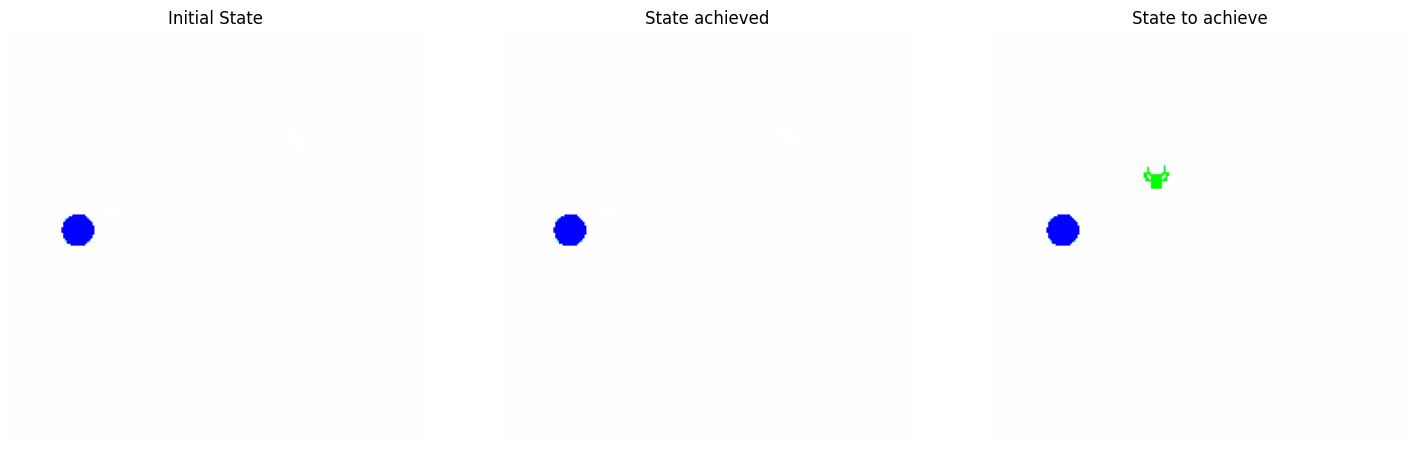

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test22/022.png

 ********************** Delta Values : ********************
tensor([[-2.9907,  0.3865]], device='cuda:0')


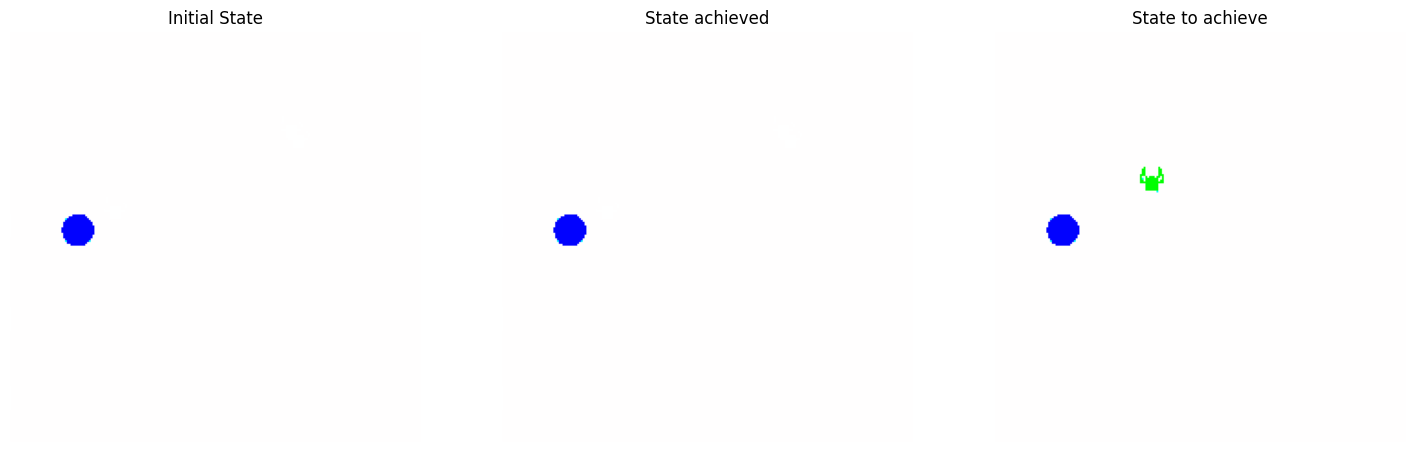

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test23/023.png

 ********************** Delta Values : ********************
tensor([[-2.9159,  0.3971]], device='cuda:0')


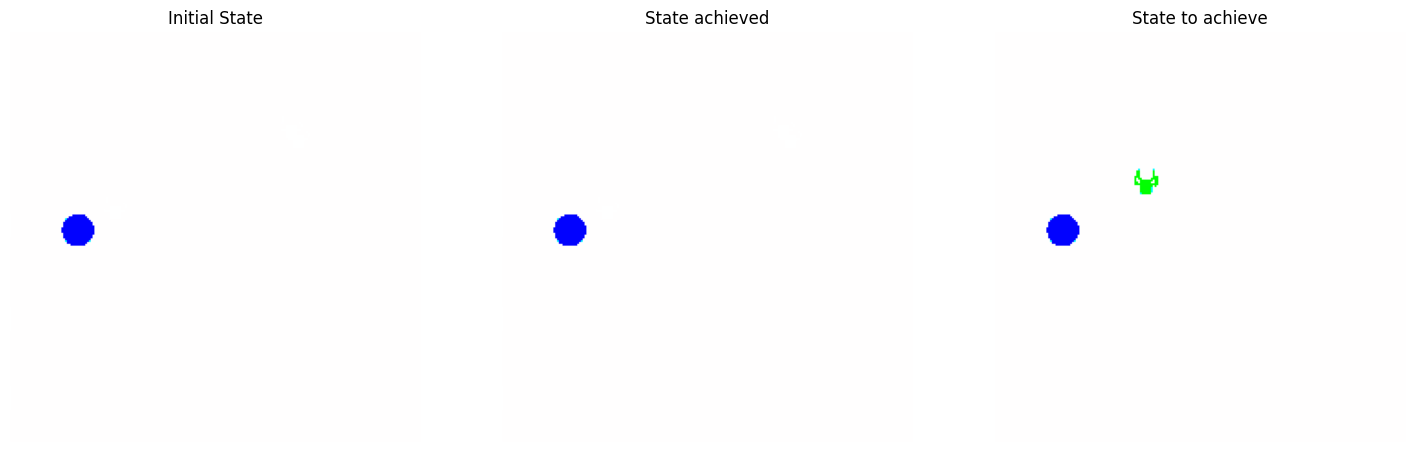

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test24/024.png

 ********************** Delta Values : ********************
tensor([[-2.9190,  0.4116]], device='cuda:0')


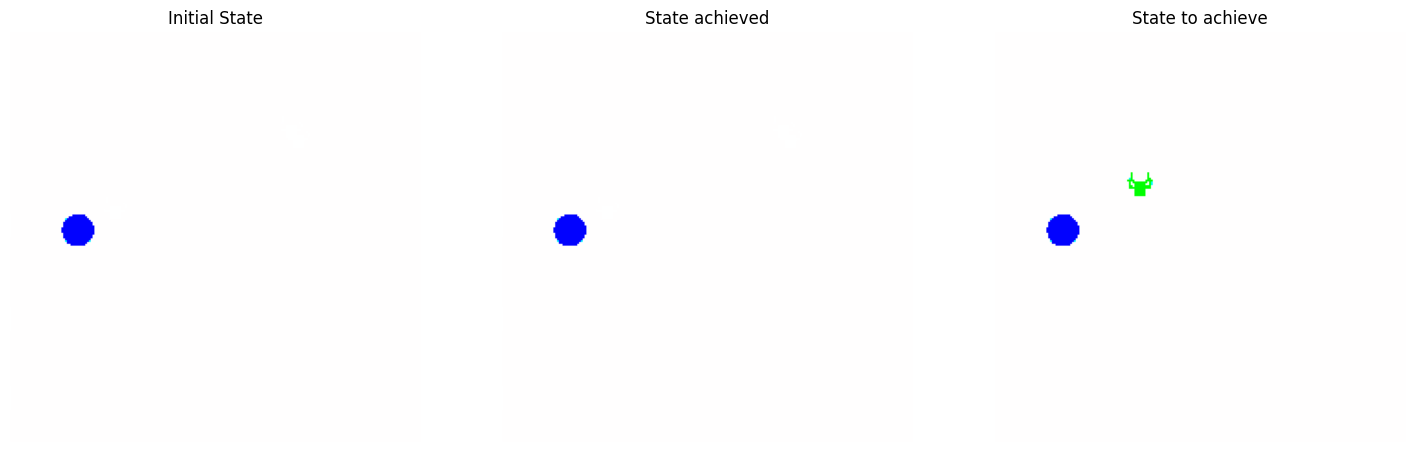

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test25/025.png

 ********************** Delta Values : ********************
tensor([[-2.8624,  0.4183]], device='cuda:0')


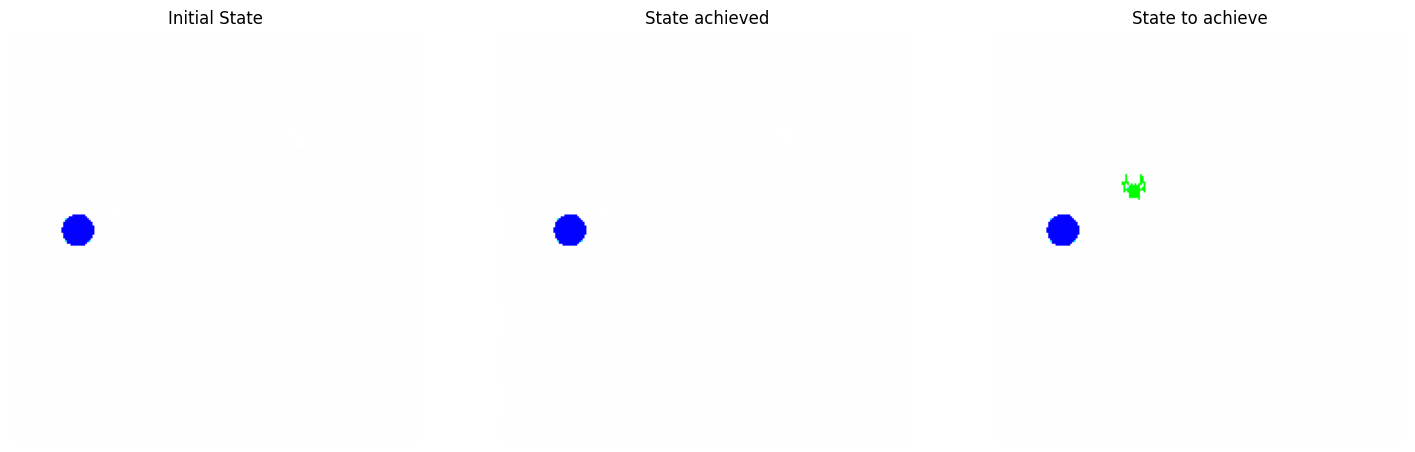

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test26/026.png

 ********************** Delta Values : ********************
tensor([[-2.8872,  0.3431]], device='cuda:0')


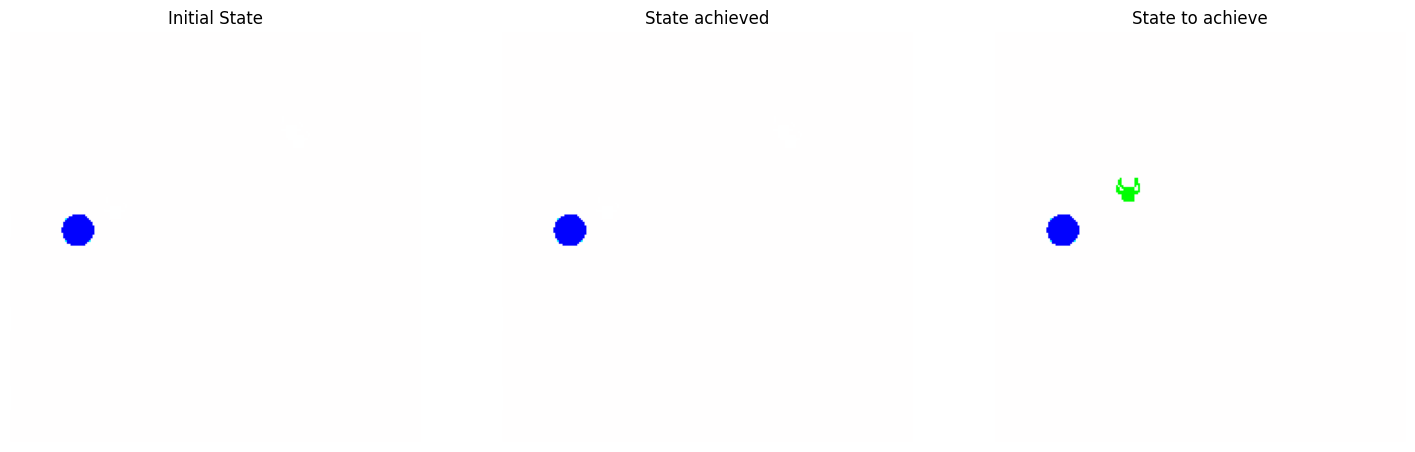

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test27/027.png

 ********************** Delta Values : ********************
tensor([[-2.9227,  0.3239]], device='cuda:0')


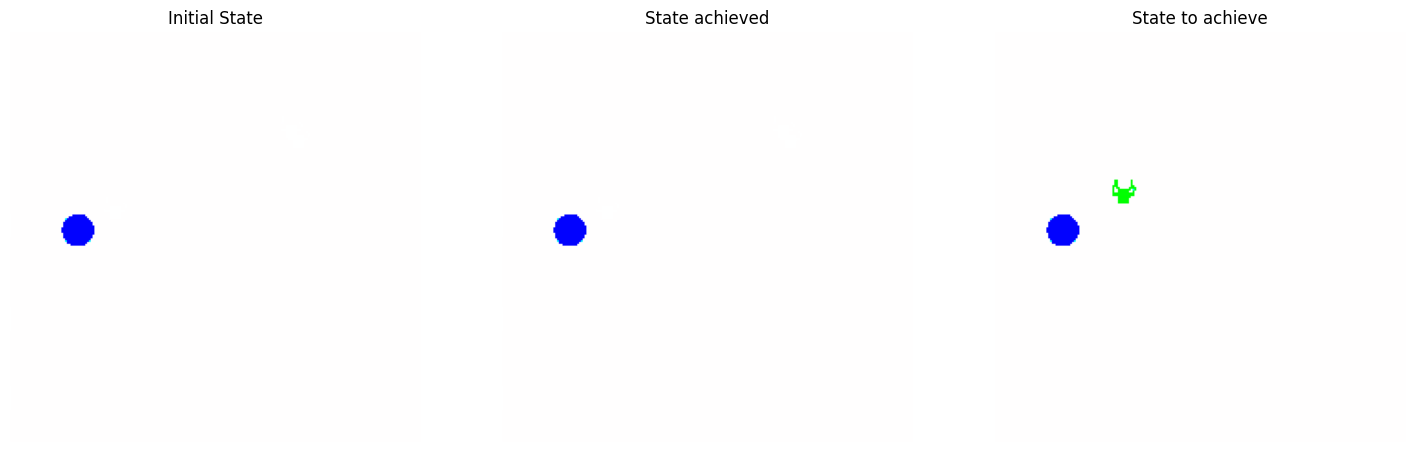

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test28/028.png

 ********************** Delta Values : ********************
tensor([[-2.8760,  0.3684]], device='cuda:0')


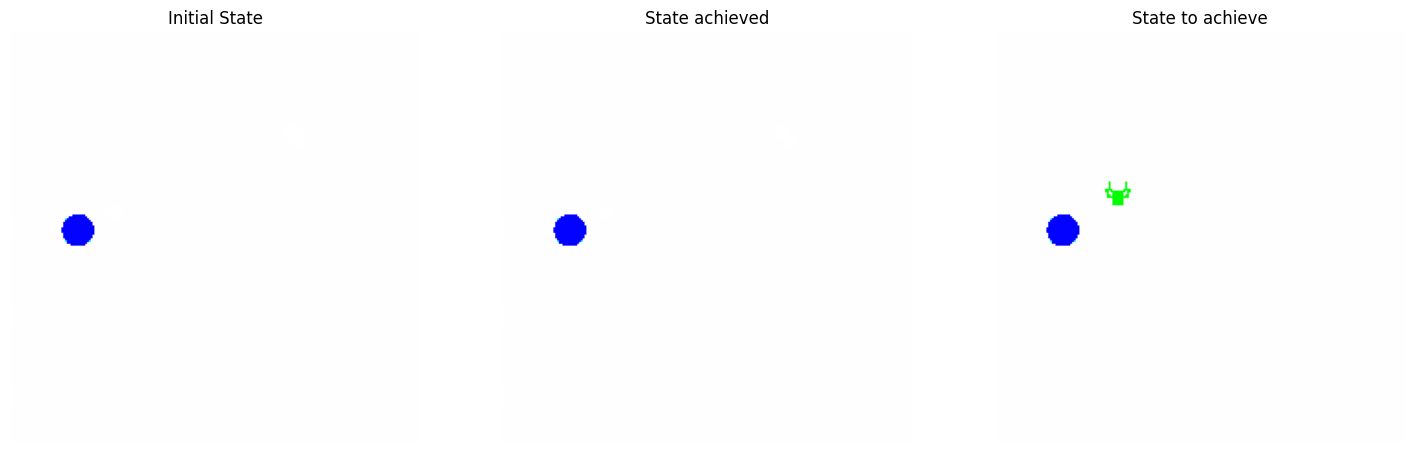

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test29/029.png

 ********************** Delta Values : ********************
tensor([[-2.8965,  0.3356]], device='cuda:0')


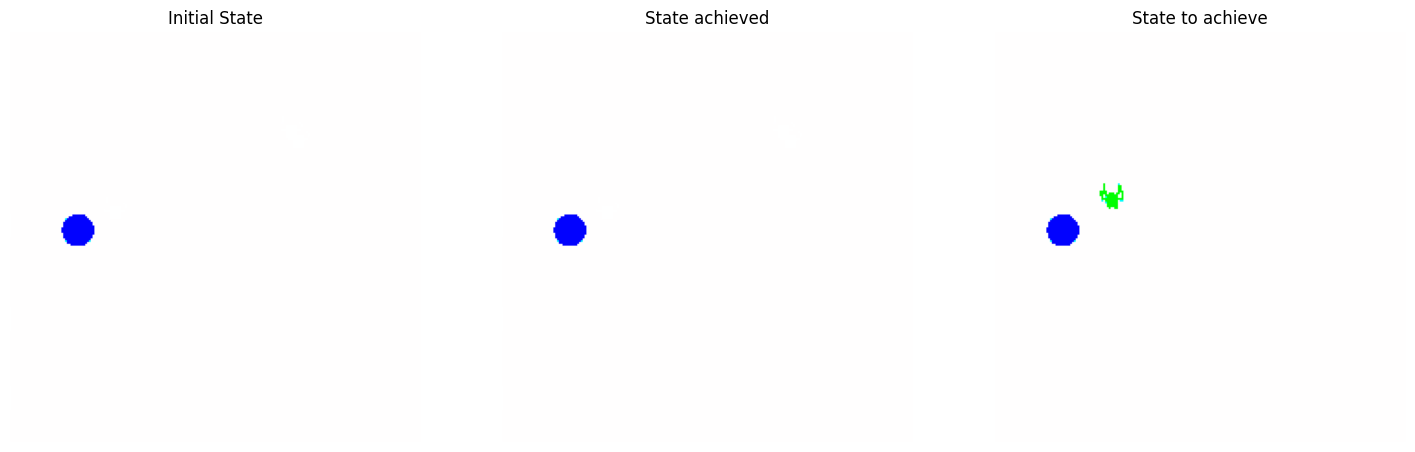

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test30/030.png

 ********************** Delta Values : ********************
tensor([[-2.9613,  0.3345]], device='cuda:0')


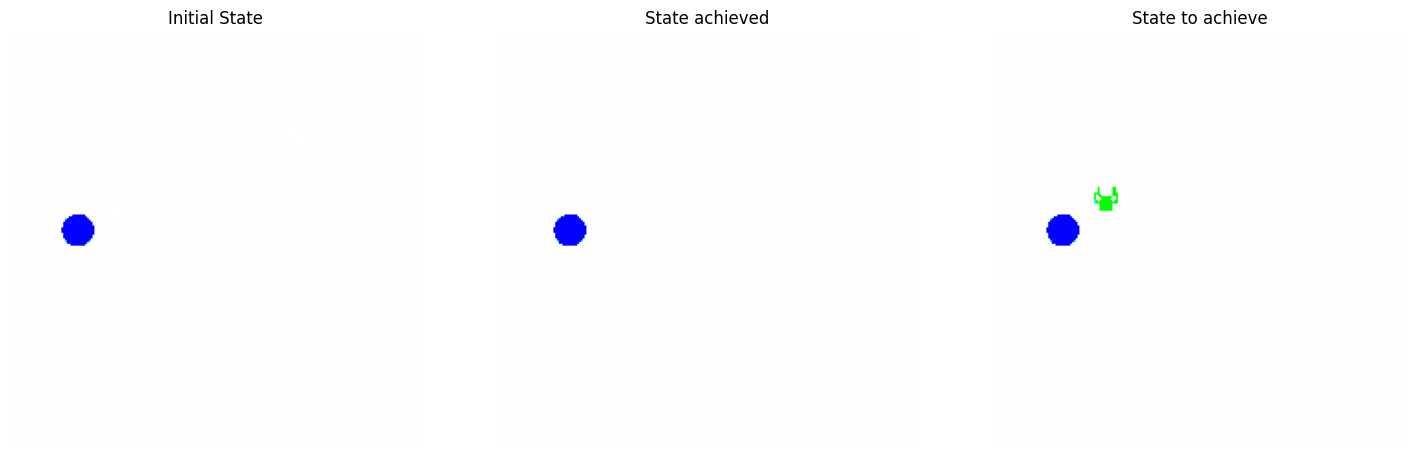

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test31/031.png

 ********************** Delta Values : ********************
tensor([[-2.9185,  0.3824]], device='cuda:0')


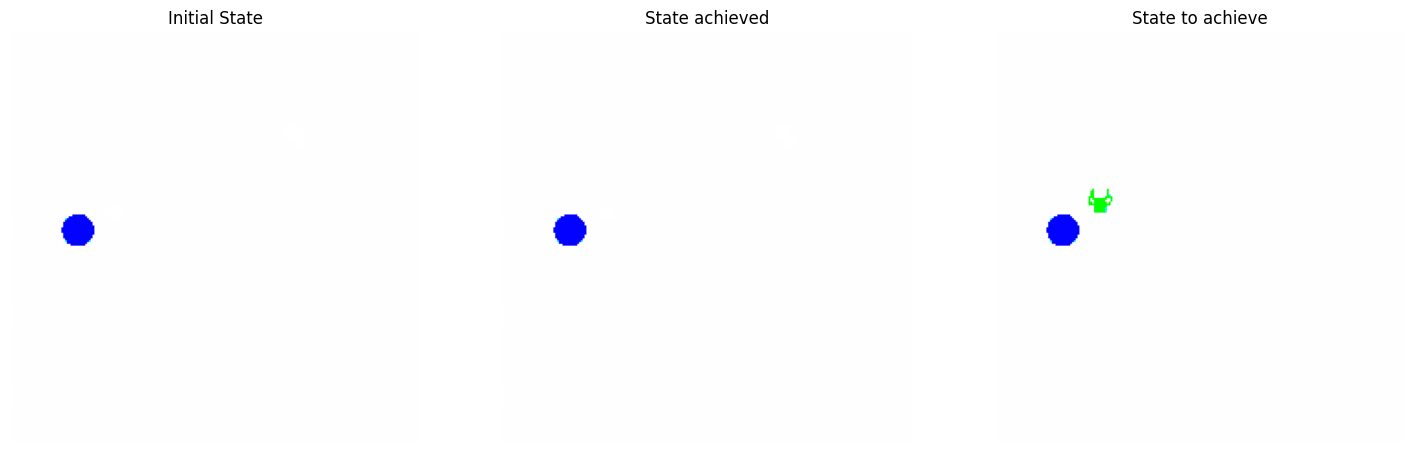

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test32/032.png

 ********************** Delta Values : ********************
tensor([[-2.9312,  0.3852]], device='cuda:0')


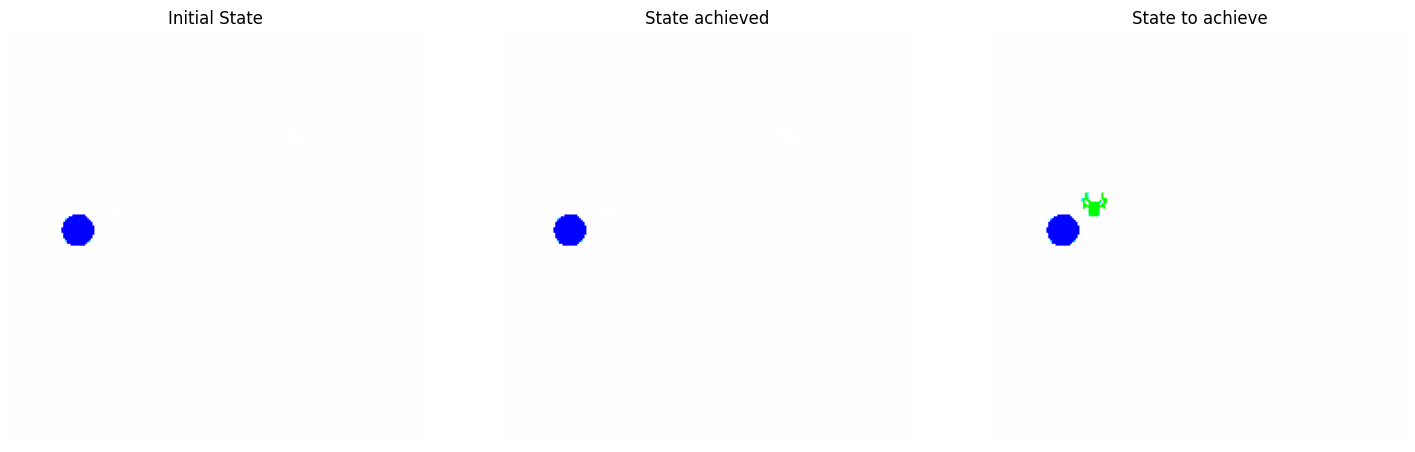

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test33/033.png

 ********************** Delta Values : ********************
tensor([[-2.8871,  0.4107]], device='cuda:0')


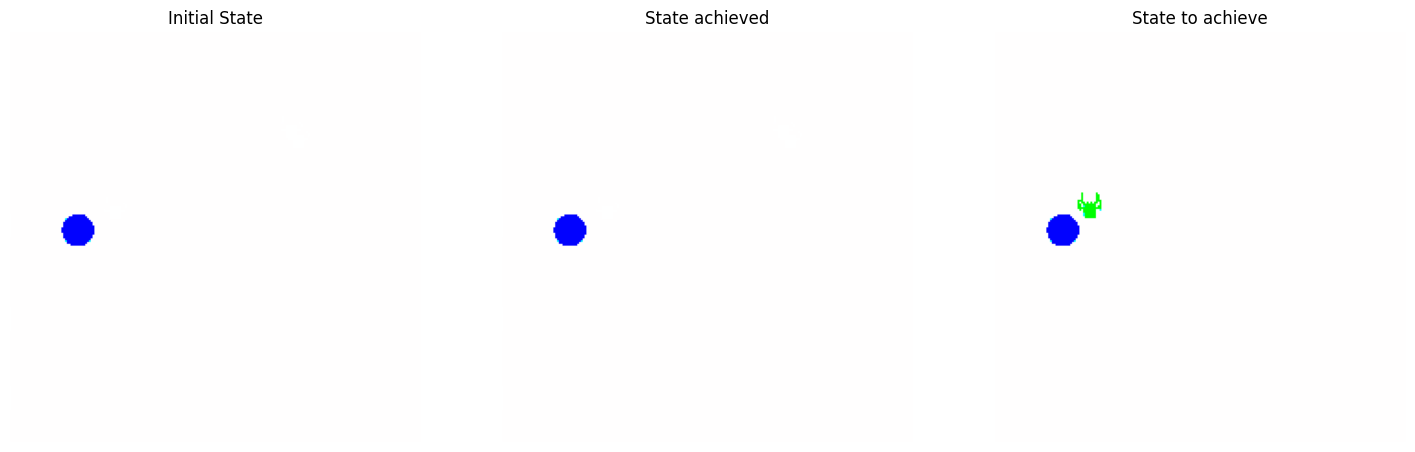

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test34/034.png

 ********************** Delta Values : ********************
tensor([[-2.8852,  0.4027]], device='cuda:0')


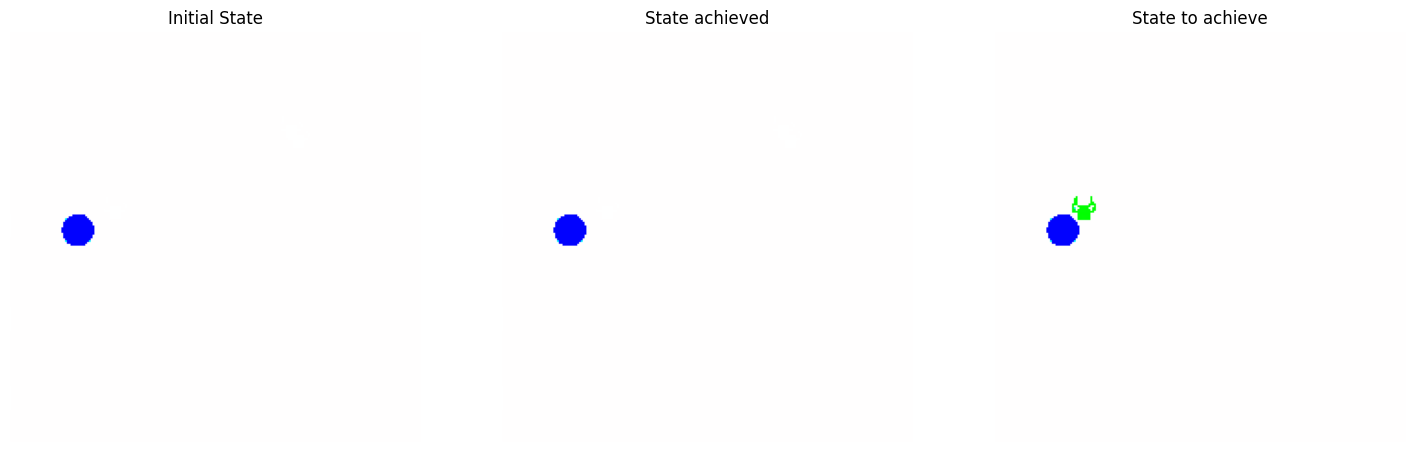

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test35/035.png

 ********************** Delta Values : ********************
tensor([[-2.9002,  0.4164]], device='cuda:0')


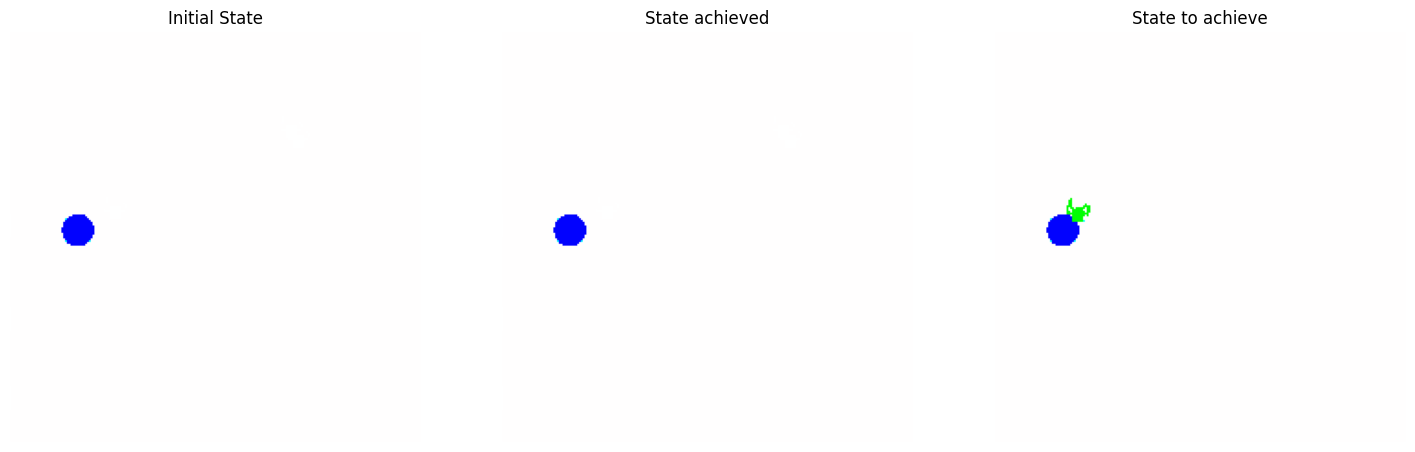

***************** Images Considered ************************
/content/marker_images_test/marker_images_test/1681324565/test36/036.png

 ********************** Delta Values : ********************
tensor([[-2.8896,  0.4631]], device='cuda:0')


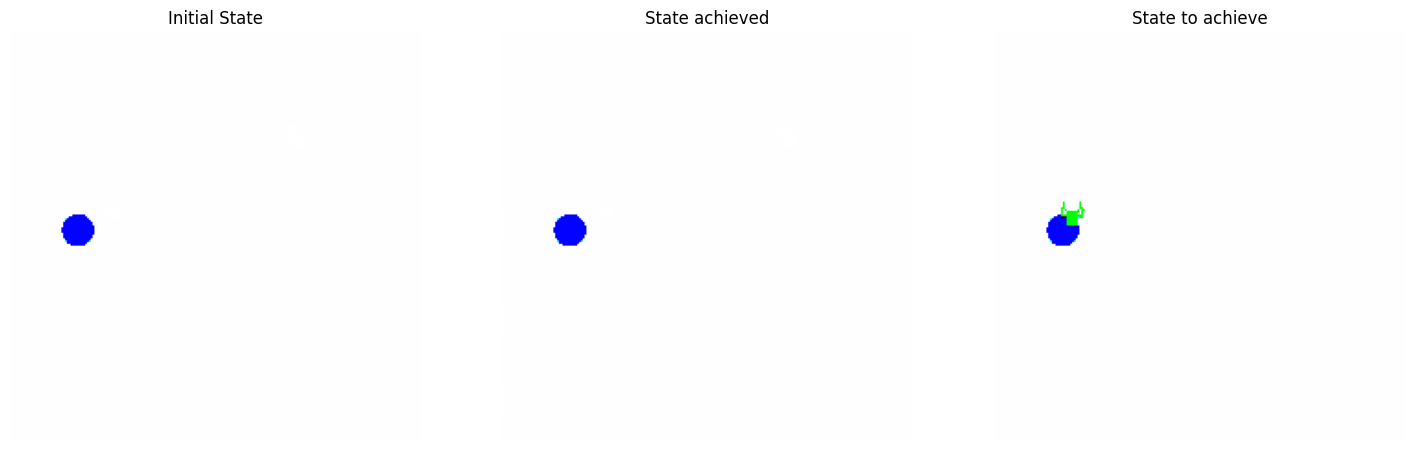

Folder 1 is Done ! 


In [59]:
data_dir = "/content/marker_images_test"
folder = load_data(data_dir)

folder_num = 1

for sub_folder in folder:
  if (folder_num == 2) :
    print ("Folder 1 is Done ! ")
    break

  else :
    rollout_experiment(model, sub_folder)
    folder_num += 1

In [60]:

'''
import matplotlib.pyplot as plt
import cv2
import numpy as np

def pixels(image):
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            bgr_pixel_value = image[y, x]
            if not np.all(bgr_pixel_value == 0) and bgr_pixel_value[1] == 0  and bgr_pixel_value[0] < 100 :
                # Print the BGR and grayscale pixel values
                print(f'BGR: {bgr_pixel_value}')

image = cv2.imread('030.png')
pixel_values = pixels(image)

'''


"\nimport matplotlib.pyplot as plt\nimport cv2\nimport numpy as np\n\ndef pixels(image):\n    for y in range(image.shape[0]):\n        for x in range(image.shape[1]):\n            bgr_pixel_value = image[y, x]\n            if not np.all(bgr_pixel_value == 0) and bgr_pixel_value[1] == 0  and bgr_pixel_value[0] < 100 :\n                # Print the BGR and grayscale pixel values\n                print(f'BGR: {bgr_pixel_value}')\n\nimage = cv2.imread('030.png')\npixel_values = pixels(image)\n\n"